# Supplemental Figure 3- simulations of V1 violation rates


In [202]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils as u
import config as c

from scipy.stats import wilcoxon

from simulate_fixation_growth import SimulateV1FixationGrowth


sns.set_context("talk")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data


In [193]:
tdf = u.load_trials_df()
tdf = u.compute_days_relative_to_stage(tdf, stage=5) # note need to have first day in prove stage for days to target to turn on

Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


In [196]:

DAYS_TO_TARGET_DF = (
    tdf.query("has_reached_target_fixation == True")
    .groupby(["animal_id", "fix_experiment"], observed=True)[
        f"days_relative_to_stage_5"
    ]
    .min()
    .reset_index()
)

DAYS_TO_TARGET_DF.rename(
    columns={f"days_relative_to_stage_5": "days_to_target"},
    inplace=True,
)

# A- Example Animal


In [199]:
EXAMPLE_ANIMAL = 'R050'
r= SimulateV1FixationGrowth(tdf, animal_id=EXAMPLE_ANIMAL, experiment_name="Test Recovery", seed=30)
trials_recovery, summary_recovery = r.run_simulation()

In [198]:
r= SimulateV1FixationGrowth(tdf, animal_id=EXAMPLE_ANIMAL, experiment_name="Test Normative", wu_vr=0, pwu_vr=0, seed=30)
trials_normative, summary_normative = r.run_simulation()

In [197]:
trials_true = tdf.query("animal_id == @EXAMPLE_ANIMAL and stage in @c.GROWING_STAGES")[["animal_id", "days_relative_to_stage_5", "fixation_dur", "violations", "trial"]].copy()

trials_true["session"] = trials_true["days_relative_to_stage_5"] + 1

trials_true.head()

,animal_id,days_relative_to_stage_5,fixation_dur,violations,trial,session
103588,R050,0,0.010,0,1,1
103589,R050,0,0.011,0,2,1
103590,R050,0,0.012,0,3,1
103591,R050,0,0.013,0,4,1
103592,R050,0,0.014,0,5,1


In [210]:
ex_animal_df =tdf.query("animal_id == @EXAMPLE_ANIMAL and stage in @c.GROWING_STAGES")

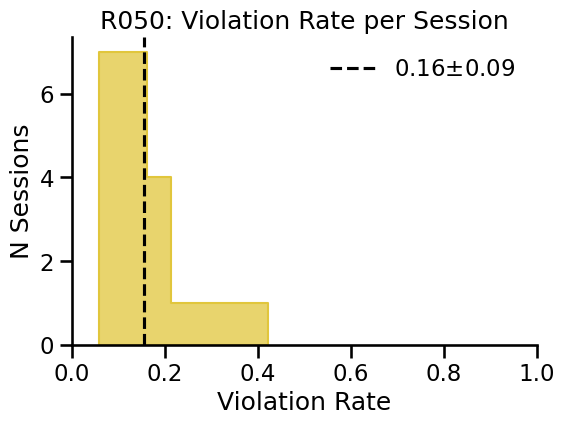

In [279]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.despine()
viol_df = ex_animal_df.groupby("date")["violations"].mean()
sns.histplot(viol_df, ax=ax, color=c.VIOLATION_COLOR, element="step")


mean = viol_df.mean()
std = viol_df.std()
ax.axvline(mean, color="k", linestyle="--", label=f'{mean:.2f}$\pm${std:.2f}')
ax.set_xlim(0, 1)
ax.set_ylabel("N Sessions")
ax.set_xlabel("Violation Rate")
ax.legend(frameon=False)
ax.set_title("R050: Violation Rate per Session")

c.save_fig(fig, "figs3_R050_violation_rate_per_session")

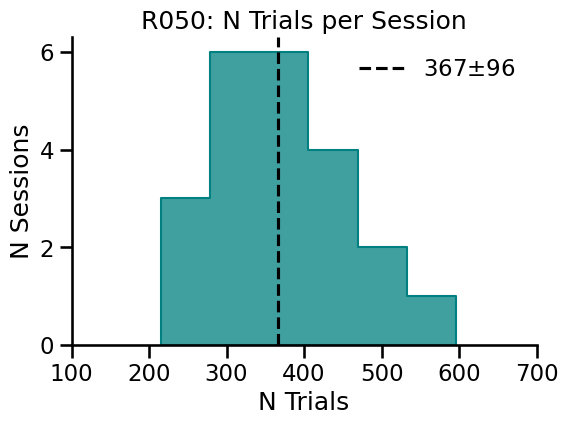

In [280]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.despine()
trials_df = ex_animal_df.groupby(["date"])["trial"].max()
sns.histplot(trials_df, ax=ax, color="teal", element="step")
#plot median line

mean = trials_df.mean()
std = trials_df.std()
ax.axvline(mean, color="k", linestyle="--", label=f'{mean:.0f}$\pm${std:.0f}')
ax.set_xlim(100, 700) 
ax.set_ylabel("N Sessions")
ax.set_xlabel("N Trials")
ax.legend(frameon=False)
ax.set_title("R050: N Trials per Session")
c.save_fig(fig, "figs3_R050_n_trials_per_session")


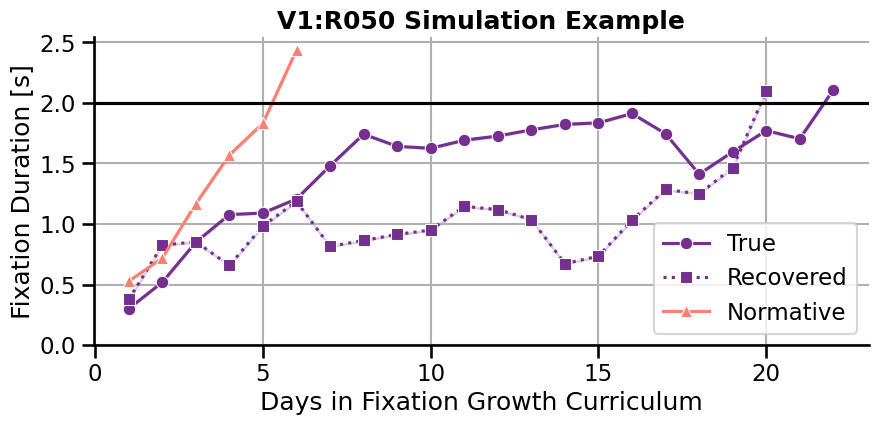

In [282]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.despine()

sns.lineplot(data=trials_true, x="session", y="fixation_dur", ax=ax, estimator="max", marker="o", label="True", color= c.V1_COLOR)
sns.lineplot(data=trials_recovery, x="session", y="fixation_dur", ax=ax, estimator="max", marker="s", label="Recovered", color=c.V1_COLOR, linestyle=":")
sns.lineplot(data=trials_normative, x="session", y="fixation_dur", ax=ax, estimator="max", marker="^", label="Normative", color="salmon")

ax.grid()
ax.axhline(y=2, color="k")
ax.set_title("V1:R050 Simulation Example", fontweight="bold")
ax.set_xlabel("Days in Fixation Growth Curriculum")
ax.set_ylabel("Fixation Duration [s]")
ax.set_ylim(0, None)

c.save_fig(fig, "figs3_r050_example_simulation")


## multi animal


In [261]:
animals = ['R040','R042','R046','R048','R050','R052','R054','R056']
seeds = list(range(30))   # or however many you like
records = []
for animal in animals:
    for mode_label, wu_vr, pwu_vr in [
        ("recovered", None, None),
        ("normative", 0.0, 0.0),
    ]:
        for seed in seeds:
            sim = SimulateV1FixationGrowth(
                tdf,
                animal_id=animal,
                wu_vr=wu_vr,
                pwu_vr=pwu_vr,
                experiment_name=mode_label,
                seed=seed
            )
            _, summary = sim.run_simulation()
            records.append({
                "animal_id": animal,
                "seed": seed,
                "days_to_target": summary["simulated_days_to_target"],
                "mode": mode_label
            })

df_days = pd.DataFrame.from_records(records)
mean_df = (
    df_days
    .groupby(["animal_id","mode"])["days_to_target"]
    .mean()
    .reset_index()
)


In [262]:
DAYS_TO_TARGET_DF["mode"] = DAYS_TO_TARGET_DF["fix_experiment"].apply(lambda x: "true_V1" if x == "V1" else "true_V2")
mean_df["fix_experiment"] = "V1"

summary_df = pd.concat([mean_df, DAYS_TO_TARGET_DF], ignore_index=True)

Wilcoxon signed‐rank: W = 12.500, p = 0.547




/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_31842/988949964.py:8: UserWarning: 
The palette list has fewer values (8) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(


,mode,mean,std
0,recovered,34.529167,20.128180
1,true_V1,29.000000,18.369229


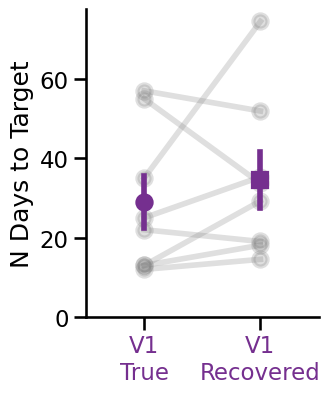

In [267]:
fig, ax = plt.subplots(figsize=(3, 4))

ORDER = ["true_V1", "recovered", ]
X_LABELS = ["V1\nTrue", "V1\nRecovered",]
COLORS = [c.V1_COLOR, c.V1_COLOR]


sns.pointplot(
    data=summary_df,
    x="mode",
    y="days_to_target",
    ax=ax,
    hue="animal_id",
    palette=["gray"] * 8,
    alpha=0.25,
    order=ORDER
)

sns.pointplot(
    data=summary_df.query("mode in @ORDER"),
    x="mode",
    y="days_to_target",
    ax=ax,
    errorbar="se",
    color=c.V1_COLOR,
    hue="mode",
    palette=COLORS,
    order=ORDER,
    markers=['s', 'o'],
    linestyle=None
)
ax.set_xticks(range(len(X_LABELS)))
ax.set_xticklabels(X_LABELS, rotation=0)
tick_labels = ax.get_xticklabels()
for label, color in zip(tick_labels, COLORS):
    label.set_color(color)



sns.despine()
ax.set_ylim(0,)
ax.set_ylabel("N Days to Target")
ax.set_xlabel("")

ax.legend().remove()
c.save_fig(fig, "figs3_summary_v1_recovery_vs_true")


v1_wide = (
    summary_df
    .query("mode in @ORDER")
    .pivot(index="animal_id", columns="mode", values="days_to_target")
    [ORDER]   # ensure correct column order
    .dropna()  # (optional) drop any animals missing one mode
)

stat_w, p_w = wilcoxon(v1_wide["recovered"], v1_wide["true_V1"])
print(f"Wilcoxon signed‐rank: W = {stat_w:.3f}, p = {p_w:.3f}\n\n")

summary_df.query("mode in @ORDER").groupby("mode")["days_to_target"].agg(["mean", "std"]).reset_index()


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_31842/1999650954.py:8: UserWarning: 
The palette list has fewer values (8) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(


Normative: 8 samples, True V2: 9 samples
Mann–Whitney U = 5.000, p = 0.003
→ Significant difference (p < 0.05)




,mode,mean,std
0,normative,5.879167,1.372743
1,true_V2,11.444444,5.456902


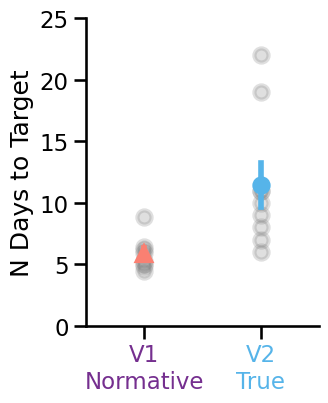

In [266]:
fig, ax = plt.subplots(figsize=(3, 4))
ORDER = ["normative", "true_V2"]
X_LABELS = ["V1\nNormative", "V2\nTrue"]
COLORS = ["salmon", c.V2_COLOR]
COLORS_X = [c.V1_COLOR, c.V2_COLOR]


sns.pointplot(
    data=summary_df,
    x="mode",
    y="days_to_target",
    ax=ax,
    hue="animal_id",
    palette=["gray"] * 8,
    alpha=0.25,
    order=ORDER
)

sns.pointplot(
    data=summary_df.query("mode in @ORDER"),
    x="mode",
    y="days_to_target",
    ax=ax,
    errorbar="se",
    color=c.V1_COLOR,
    hue="mode",
    palette=COLORS,
    order=ORDER,
    markers=['^', 'o'],
    linestyle=None
)
ax.set_xticks(range(len(X_LABELS)))
ax.set_xticklabels(X_LABELS, rotation=0)
tick_labels = ax.get_xticklabels()
for label, color in zip(tick_labels, COLORS_X):
    label.set_color(color)



sns.despine()
ax.set_ylim(0, 25)
ax.set_ylabel("N Days to Target")
ax.set_xlabel("")
ax.legend().remove()
c.save_fig(fig, "figs3_summary_normative_v1_vs_v2")

import pandas as pd
from scipy.stats import mannwhitneyu

# 1. Extract the two groups from your summary_df
norm = summary_df.query("mode == 'normative'")["days_to_target"]
true_v2 = summary_df.query("mode == 'true_V2'")["days_to_target"]

# 2. Check group sizes
print(f"Normative: {len(norm)} samples, True V2: {len(true_v2)} samples")

# 3. Run Mann–Whitney U (two‐sided)
stat, p = mannwhitneyu(norm, true_v2, alternative="two-sided")
print(f"Mann–Whitney U = {stat:.3f}, p = {p:.3f}")

# 4. Interpret
alpha = 0.05
if p < alpha:
    print("→ Significant difference (p < 0.05)\n\n")
else:
    print("→ No significant difference (p ≥ 0.05)\n\n")

summary_df.query("mode in @ORDER").groupby("mode")["days_to_target"].agg(["mean", "std"]).reset_index()




In [165]:
summary_df

,animal_id,mode,days_to_target,fix_experiment
0,R040,normative,5.066667,V1
1,R040,recovered,18.100000,V1
2,R042,normative,4.433333,V1
3,R042,recovered,14.533333,V1
4,R046,normative,5.966667,V1
5,R046,recovered,29.233333,V1
6,R048,normative,4.900000,V1
7,R048,recovered,74.466667,V1
8,R050,normative,5.266667,V1
9,R050,recovered,19.033333,V1


In [157]:
summary_df.query("mode in @ORDER").pivot(index="animal_id", columns="mode", values="days_to_target")[ORDER]

mode,normative,true_V2
animal_id,,
R040,5.066667,NaN
R041,NaN,11.0
R042,4.433333,NaN
R043,NaN,6.0
R045,NaN,11.0
R046,5.966667,NaN
R047,NaN,22.0
R048,4.900000,NaN
R049,NaN,10.0


# Common Wrangle & EDA

This is how I made decision about the distribution types to use (noraml and gamma)


In [ ]:

DAYS_TO_TARGET_DF = (
    tdf.query("has_reached_target_fixation == True")
    .groupby(["animal_id", "fix_experiment"], observed=True)[
        f"days_relative_to_stage_5"
    ]
    .min()
    .reset_index()
)

DAYS_TO_TARGET_DF.rename(
    columns={f"days_relative_to_stage_5": "days_to_target"},
    inplace=True,
)

DAYS_TO_TARGET_DF

,animal_id,fix_experiment,days_to_target
0,R040,V1,13
1,R041,V2,11
2,R042,V1,12
3,R043,V2,6
4,R045,V2,11
5,R046,V1,13
6,R047,V2,22
7,R048,V1,35
8,R049,V2,10
9,R050,V1,22


(0.0, 1.0)

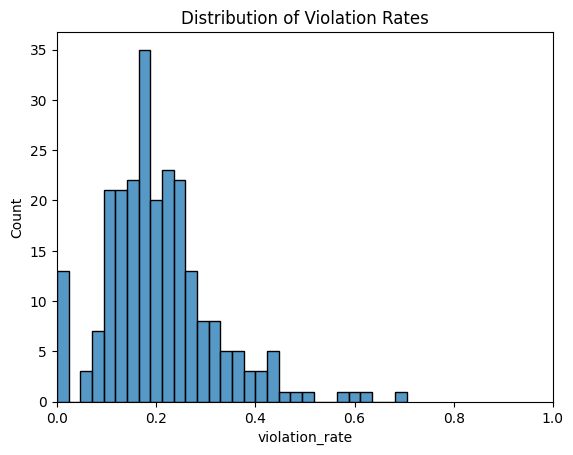

In [ ]:
summary_animals = tdf.query("stage in @c.GROWING_STAGES and fix_experiment == 'V1'").groupby(["animal_id", "date", "days_relative_to_stage_5"]).agg(
    n_trials=("trial", "nunique"),
    violation_rate=("violations", "mean")
    ).reset_index()


fig, ax = plt.subplots()
sns.histplot(summary_animals, x="violation_rate", bins=30, ax=ax)
ax.set_title("Distribution of Violation Rates")
plt.xlim(0, 1)

Text(0.5, 1.0, 'Distribution of Number of Trials')

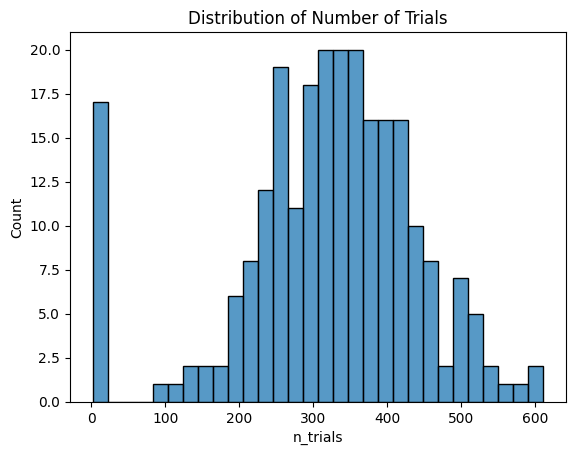

In [ ]:
fig, ax = plt.subplots()
sns.histplot(summary_animals, x="n_trials", bins=30, ax=ax)
ax.set_title("Distribution of Number of Trials")

<Axes: xlabel='n_trials', ylabel='violation_rate'>

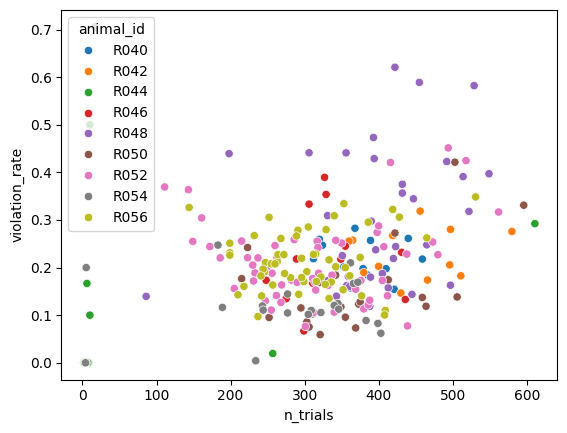

In [ ]:
sns.scatterplot(data=summary_animals, x="n_trials", y="violation_rate", hue="animal_id")

# Figure 3Y- Days to Complete Stage 5


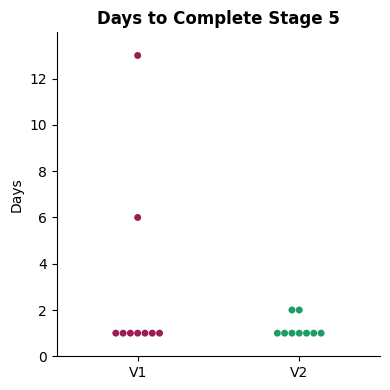

In [134]:
plot_df = (
    tdf.query("stage==5").groupby(["animal_id", "stage", "fix_experiment"], observed=True)
    .agg(n_days=pd.NamedAgg(column="date", aggfunc="nunique"))
    .reset_index()
)
plot_df
fig, ax = plt.subplots(figsize=(4,4))

sns.swarmplot(
    data=plot_df,
    x="fix_experiment",
    y="n_days",
    ax=ax,
    palette=c.EXP_PALETTE,
    hue="fix_experiment",
    order=c.HUE_ORDER_EXP,
)
sns.despine()

_ = ax.set_yticks(range(0, 14, 2))
_ = ax.set(ylabel="Days", xlabel="", ylim=(0, 14))

ax.set_title("Days to Complete Stage 5", fontweight="bold")

plt.tight_layout()
plt.savefig("figures/V0_figs3b_days_to_complete_stage_5.png", dpi=300, bbox_inches="tight")
